# Turn around Tuesday

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

import activity as act
import utils as self_utils
from quantified_strategies import utils

C:\Users\tomw1\AppData\Local\Temp\ipykernel_14592\2173995081.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
START = dt.date(2015, 1, 1)
# START = dt.date(2010, 1, 1)
END = dt.date.today()

In [3]:

def run(ticker: str, start: dt.date = START, end: dt.date = END) -> pd.DataFrame:

    def calculate_strategy_returns(df: pd.DataFrame) -> pd.DataFrame:
        df["strat_ret"] = df["ret_shifted"] * df["pos"]
        df["cum_strat_ret"] = utils.get_cumulative_return(returns=df["strat_ret"], total=False)
        df["cum_hodl_ret"] = utils.get_cumulative_return(returns=df["ret_shifted"], total=False)
        return df

    def calculate_trade_returns(df: pd.DataFrame) -> pd.DataFrame:
        
        df["trade_number"] = df["enter_flag"].cumsum()
        
        trade_ret = (
            df
            .dropna(subset="strat_ret")
            .groupby("trade_number")["strat_ret"]
            .apply(lambda ret: utils.get_cumulative_return(returns=ret, total=True))
        )
        trade_ret.index = trade_ret.index.map(df.loc[df["enter_flag"]].reset_index().set_index("trade_number")["Date"].to_dict())
        trade_ret = trade_ret.loc[~trade_ret.index.isna()]

        df = pd.concat([df, trade_ret.to_frame(name="trade_strat_ret")], axis=1)

        return df
        
    # Get Data
    data = utils.get_data(ticker=ticker, columns=["Adj Close", "High"])
    data = data.rename(columns={"Adj Close": "asset", "High": "asset_high"})

    # Filter data
    data = data.loc[(data.index.date >= START) & (data.index.date <= END)].copy()

    # Convert data
    data["ret"] = data["asset"].pct_change()
    data["ret_shifted"] = data["ret"].shift(-1)

    # Get Activity
    data["active"] = act.get_activity(data=data)
    data["pos"] = data["active"].astype(int)
    
    # Calculate Returns
    data = calculate_strategy_returns(df=data)

    # Calculate Trade Returns
    data = calculate_trade_returns(df=data)
    
    return data


## Rules

1. Today must be a Monday
2. The Close must be lower than Friday's close
3. If 1 and 2 are true, then buy at the close
4. Sell when today's close is higher than yesterday's high or after 5 trading days.

In [15]:
TICKERS = ["SPY", "QQQ"]
TICKERS = ["XLK", "XLB", "XLY"]

In [16]:
data_dict = {ticker: run(ticker=ticker) for ticker in TICKERS}

## Plot Strategy Results

In [28]:
TICKER = TICKERS[2]
data = data_dict[TICKER]

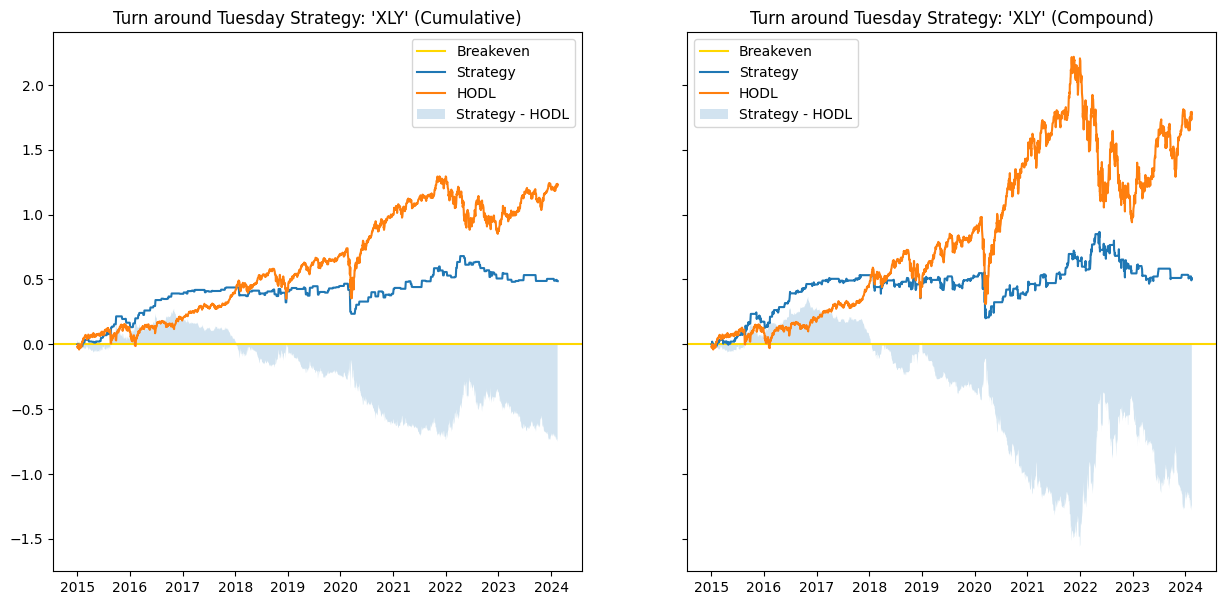

In [29]:
fig, ax = plt.subplots(ncols=2, sharey=1, figsize=(15, 7))

ax[0].axhline(y=0, label="Breakeven", color="gold")
ax[1].axhline(y=0, label="Breakeven", color="gold")

ax[0].plot(data["trade_strat_ret"].fillna(0.0).cumsum(), label="Strategy")
ax[0].plot(data["ret_shifted"].cumsum(), label="HODL")
ax[0].fill_between(
    data.index.tolist(), 
    data["trade_strat_ret"].fillna(0.0).cumsum()-data["ret_shifted"].cumsum(),
    alpha=0.20,
    label="Strategy - HODL",
)
ax[0].set_title(f"Turn around Tuesday Strategy: {TICKER!r} (Cumulative)")
ax[0].legend(loc="best")

ax[1].plot(data["cum_strat_ret"], label="Strategy")
ax[1].plot(data["cum_hodl_ret"], label="HODL")
ax[1].fill_between(
    data.index.tolist(), 
    data["cum_strat_ret"] - data["cum_hodl_ret"],
    alpha=0.20,
    label="Strategy - HODL",
)
ax[1].set_title(f"Turn around Tuesday Strategy: {TICKER!r} (Compound)")
ax[1].legend(loc="best")


plt.show()

## Describe Strategy Results

In [30]:
pd.concat([
    utils.describe(returns=data["strat_ret"], pos=data["pos"], daily=True, asset=TICKER).to_frame(name="daily_strategy"),
    utils.describe(returns=data["trade_strat_ret"].dropna(), daily=False, asset=TICKER).to_frame(name="trade_strategy"),
    utils.describe(returns=data["ret_shifted"], daily=True, asset=TICKER).to_frame(name="hodl"),
], axis=1)

,daily_strategy,trade_strategy,hodl
Asset,XLY,XLY,XLY
Start,2015-01-02,2015-01-05,2015-01-02
End,2024-02-16,2024-02-12,2024-02-16
Mean Return,0.06314%,0.28830%,0.05365%
Total Return,50.92%,50.92%,177.63%
Median Return,0.14132%,0.45958%,0.11827%
1st Quartile,-0.53232%,-1.27670%,-0.53365%
3rd Quartile,0.79785%,1.71525%,0.71622%
Std Dev Return,1.49449%,2.95724%,1.35032%
CAGR,5.185 bps,24.382 bps,4.446 bps


# Portfolio

In [20]:
hodl_rets = pd.concat([data["ret_shifted"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1).sort_index()
rets = pd.concat([data["strat_ret"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1).sort_index()
trade_rets = pd.concat([data["trade_strat_ret"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1).sort_index()
deltas = pd.concat([data["pos"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1).sort_index()
deltas = deltas.div(deltas.sum(axis=1), axis=0).fillna(0.0)

In [21]:
def calculate_trade_returns(df: pd.DataFrame, deltas: pd.Series) -> pd.DataFrame:

    df.index.name = "Date"
    df = df.loc[:, df.columns != "trade_strat_ret"]
    df["enter_flag"] = df["enter_flag"] + deltas.diff().clip(lower=0.0)
    df["strat_ret"] = df["strat_ret"] * deltas
    
    df["trade_number"] = df["enter_flag"].cumsum()
    
    trade_ret = (
        df
        .dropna(subset="strat_ret")
        .groupby("trade_number")["strat_ret"]
        .apply(lambda ret: utils.get_cumulative_return(returns=ret, total=True))
    )
    trade_ret.index = trade_ret.index.map(df.loc[df["enter_flag"] > 0].reset_index().set_index("trade_number")["Date"].to_dict())
    trade_ret = trade_ret.loc[~trade_ret.index.isna()]

    df = pd.concat([df, trade_ret.to_frame(name="trade_strat_ret")], axis=1)

    return df

port_trade_rets = pd.concat([calculate_trade_returns(df=data.copy(), deltas=deltas[ticker])["trade_strat_ret"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1)
port_trade_rets = port_trade_rets.dropna(how="all").sum(axis=1)
port_trade_rets.head(5)

2015-01-05    0.008662
2015-01-12   -0.008641
2015-01-26   -0.023498
2015-02-09    0.033411
2015-02-23    0.009626
dtype: float64

In [22]:
port_rets = (rets * deltas).sum(axis=1)
port_rets.head(5)

2015-01-02    0.000000
2015-01-05   -0.010293
2015-01-06    0.011854
2015-01-07    0.020254
2015-01-08   -0.006618
dtype: float64

In [23]:
hodl_rets = hodl_rets.mean(axis=1)
hodl_rets.head(5)

2015-01-02   -0.019960
2015-01-05   -0.010293
2015-01-06    0.011854
2015-01-07    0.020254
2015-01-08   -0.006618
dtype: float64

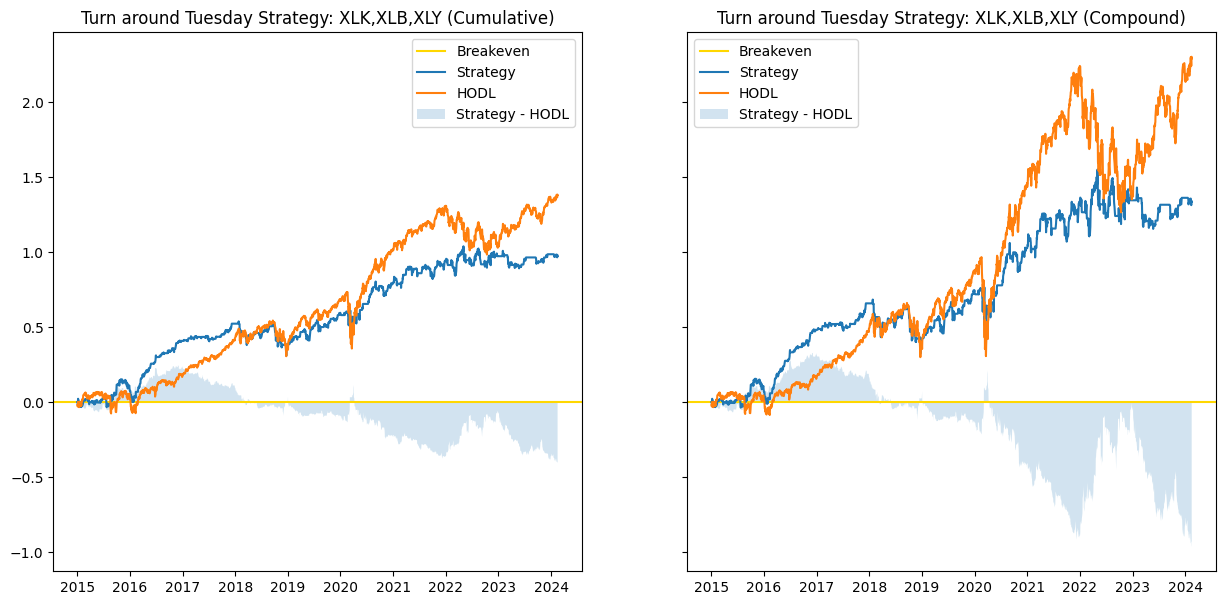

In [24]:
fig, ax = plt.subplots(ncols=2, sharey=1, figsize=(15, 7))

ax[0].axhline(y=0, label="Breakeven", color="gold")
ax[1].axhline(y=0, label="Breakeven", color="gold")

ax[0].plot(port_rets.cumsum(), label="Strategy")
ax[0].plot(hodl_rets.cumsum(), label="HODL")
ax[0].fill_between(
    data.index.tolist(), 
    port_rets.cumsum() - hodl_rets.cumsum(),
    alpha=0.20,
    label="Strategy - HODL",
)
ax[0].set_title(f"Turn around Tuesday Strategy: {','.join(TICKERS)} (Cumulative)")
ax[0].legend(loc="best")

ax[1].plot(utils.get_cumulative_return(returns=port_rets, total=False), label="Strategy")
ax[1].plot(utils.get_cumulative_return(returns=hodl_rets, total=False), label="HODL")
ax[1].fill_between(
    data.index.tolist(), 
    utils.get_cumulative_return(returns=port_rets, total=False)- utils.get_cumulative_return(returns=hodl_rets, total=False),
    alpha=0.20,
    label="Strategy - HODL",
)
ax[1].set_title(f"Turn around Tuesday Strategy: {','.join(TICKERS)} (Compound)")
ax[1].legend(loc="best")

plt.show()

In [14]:
pd.concat([
    utils.describe(returns=port_rets, pos=deltas.sum(axis=1), daily=True, asset=",".join(TICKERS)).to_frame(name="daily_strategy"),
    utils.describe(returns=port_trade_rets, daily=False, asset=",".join(TICKERS)).to_frame(name="trade_strategy"),
    utils.describe(returns=hodl_rets, daily=True, asset=",".join(TICKERS)).to_frame(name="hodl"),
], axis=1)

,daily_strategy,trade_strategy,hodl
Asset,"SPY,QQQ","SPY,QQQ","SPY,QQQ"
Start,2015-01-02,2015-01-05,2015-01-02
End,2024-02-16,2024-02-12,2024-02-16
Mean Return,0.10976%,0.47240%,0.06371%
Total Return,173.97%,176.46%,261.33%
Median Return,0.11674%,0.65708%,0.08830%
1st Quartile,-0.43867%,-0.55772%,-0.43480%
3rd Quartile,0.77356%,1.68545%,0.69341%
Std Dev Return,1.37853%,2.58773%,1.24198%
CAGR,10.023 bps,43.928 bps,5.594 bps
